zss2024 for 23MSDS-NLP course

In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

!pip install contractions -q
import contractions

!pip install textacy -q
from textacy import preprocessing

import re
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.0 MB/s eta 0:00:00


## Settings

In [2]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')

# Dataset folder from Drive
dataset_dir = '/content/drive/My Drive/Colab Notebooks/NLP/toast-roast-dataset'

roast_files = [
    'Train__Roast.xlsx',
    'Val__Roast.xlsx',
    'Test__Roast.xlsx',
]
toast_files = [
    'Train__Toast.xlsx',
    'Val__Toast.xlsx',
    'Test__Toast.xlsx',
]


## Read dataset

In [3]:
# Read roast/toast files and concatenate into a single dataset
roast_frames = [pd.read_excel(f"{dataset_dir}/{name}", index_col=None) for name in roast_files]
toast_frames = [pd.read_excel(f"{dataset_dir}/{name}", index_col=None) for name in toast_files]

df_roast = pd.concat(roast_frames, ignore_index=True).assign(label=0)
df_toast = pd.concat(toast_frames, ignore_index=True).assign(label=1)
df = pd.concat([df_roast, df_toast], ignore_index=True)

text_all = df["text"].astype(str).to_list()
labels = df["label"].to_numpy()

print(len(text_all), labels.shape, np.unique(labels), sum(labels==0), sum(labels==1))


1000 (1000,) [0 1] 500 500


## Preprocessing

In [4]:
# Define function for punctuation removal
def f_punctuation_removal(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

# Define function for whitespace normalization
def f_whitespace_normalization(text):
  text = re.sub('[\s]+', ' ', text).strip()
  return text

# Remove contractions
text_all = [contractions.fix( text_current, slang=False) for text_current in text_all]

# Other steps... (feel free to add/remove as per your informed choice)
text_data = []

for text_curr in text_all:

  # - Tokenize
  tokens = word_tokenize(text_curr)

  # - Lemmatize
  lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]

  # - Remove stopwords
  filtered_tokens = [token for token in lemmatized_tokens if token not in stop_words]

  # - Convert from tokens to sentence, lower case, punctuation removal,and append to list
  sent = " ".join( filtered_tokens ).lower()
  sent = f_punctuation_removal( sent )

  # - Remove hashtags, user handles, emojis, urls, quotation marks, brackets, numbers
  sent = preprocessing.replace.hashtags( sent, repl=" ")
  sent = preprocessing.replace.user_handles( sent, repl=" ")
  sent = preprocessing.replace.emojis( sent, repl=" ")
  sent = preprocessing.replace.urls( sent, repl=" ")

  sent = preprocessing.normalize.quotation_marks( sent )
  sent = preprocessing.remove.html_tags( sent )
  sent = preprocessing.remove.brackets( sent )
  sent = re.sub('"', '', sent)
  sent = re.sub("'", '', sent)
  sent = preprocessing.replace.numbers( sent, repl=" " )

  # - Normalize whitespace
  sent = f_whitespace_normalization( sent )

  # - Append to list
  text_data.append( sent )



## Text Classification pipeline

In [5]:
# Split the dataset into training and testing subsets (80% train, 20% test)
text_Train, text_Test, Labs_Train, Labs_Test = train_test_split(text_data, labels, test_size=0.2, stratify=labels, random_state=0)

print( len(text_Train), sum(Labs_Train)/len(Labs_Train), len(text_Test), sum(Labs_Test)/len(Labs_Test) )

800 0.5 200 0.5


In [6]:
# Set custom hyperparameters for TfidfVectorizer
vectorizer = TfidfVectorizer( ngram_range=(1, 2),  # Consider unigrams and bigrams
                              max_features=5000  # Limit the number of features to 5000
                              )

In [7]:
# Apply TfidfVectorizer with custom hyperparameters to transform the text data into numerical features
Feats_Train_tfidf = vectorizer.fit_transform( text_Train ).toarray()
Feats_Test_tfidf = vectorizer.transform( text_Test ).toarray()

print( Feats_Train_tfidf.shape, Feats_Test_tfidf.shape )

(800, 5000) (200, 5000)


In [8]:
print( np.mean(Feats_Train_tfidf[:,0]), np.std(Feats_Train_tfidf[:,0]) )

0.000435204945667871 0.008711653536622278


In [9]:
# Apply standard scaling
scaler = StandardScaler()
Feats_Train_tfidf = scaler.fit_transform( Feats_Train_tfidf )
Feats_Test_tfidf = scaler.transform( Feats_Test_tfidf )

print( Feats_Train_tfidf.shape, Feats_Test_tfidf.shape )

(800, 5000) (200, 5000)


In [10]:
print( np.mean(Feats_Train_tfidf[:,0]), np.std(Feats_Train_tfidf[:,0]) )

2.2204460492503132e-17 0.9999999999999875


              precision    recall  f1-score   support

           0       0.87      0.84      0.85       100
           1       0.84      0.87      0.86       100

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200



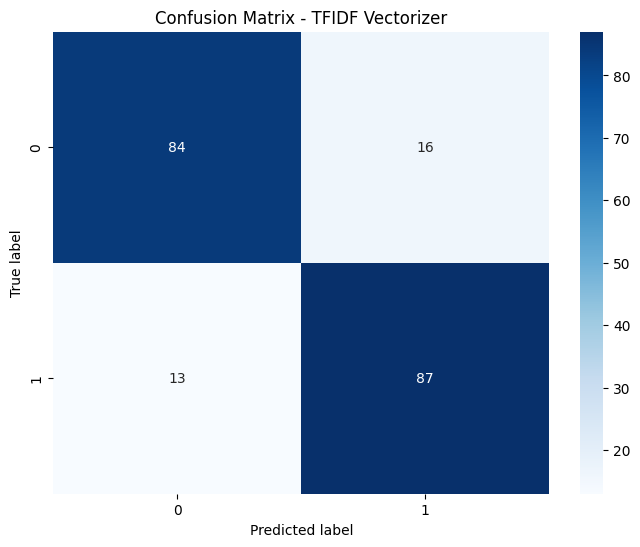

In [11]:
# Train an SVM classifier with the 'linear' kernel
clf = LinearSVC( class_weight="balanced", max_iter=1000, random_state=0)
clf.fit( Feats_Train_tfidf, Labs_Train)

# Predict the classes of the testing data
predLabs_Test = clf.predict( Feats_Test_tfidf )

# Evaluate the performance of the model using classification metrics
print(classification_report( Labs_Test, predLabs_Test ))

# Calculate the confusion matrix
cm = confusion_matrix( Labs_Test, predLabs_Test)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix - TFIDF Vectorizer')
plt.show()
